# $ARIMA(p,d,q) \, GARCH(p,q)$ modeling of the CPI
This notebook goes through the process of constructing an autoregressive integrated moving average (ARIMA) and generalized autoregressive conditional heteroskedasticity model for the consumer price index. 

First, we import necessary packages.

In [1]:
%pip install pmdarima

  Using cached pmdarima-2.0.2-cp38-cp38-win_amd64.whl (571 kB)


You should consider upgrading via the 'c:\users\forre\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.



  Using cached Cython-0.29.33-py2.py3-none-any.whl (987 kB)
  Using cached statsmodels-0.13.5-cp38-cp38-win_amd64.whl (9.2 MB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [4]:
%pip install arch

     -------------------------------------- 845.5/845.5 KB 8.9 MB/s eta 0:00:00
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\forre\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [69]:
import pmdarima
import arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

To create the ARIMA model, we will use the same parameters as before.

In [30]:
df = pd.read_csv('ALL_DATA_Marc93.csv') # read the dataframe 
cpi = df['CPI'] # pull only the CPI
X_train = cpi[:math.ceil(len(cpi) * .7)] # create the training set 
X_test = cpi[math.ceil(len(cpi) * .7):] # create the testing set 
arimaModel = pmdarima.ARIMA((1,1,2))
print('original test MSE = ', np.mean((X_train - arimaModel.fit(X_train).fittedvalues()[1:]) ** 2))
arimaModelResiduals = arimaModel.resid()[1:] # the difference of 1 requires this 


original test MSE =  0.23694398905919364


Now, we will train a $GARCH(1,2)$ model, as this is the same $p$ and $q$ from the ARIMA model.

In [36]:
garch = arch.arch_model(arimaModelResiduals,vol="Garch", p=1, q=2)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4930.639000010183
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1171.5549227091951
Iteration:      3,   Func. Count:     28,   Neg. LLF: 269.69524926943853
Iteration:      4,   Func. Count:     36,   Neg. LLF: 127.05135978192988
Iteration:      5,   Func. Count:     42,   Neg. LLF: 126.8248398192984
Iteration:      6,   Func. Count:     48,   Neg. LLF: 126.8464627693876
Iteration:      7,   Func. Count:     55,   Neg. LLF: 126.81604624137032
Iteration:      8,   Func. Count:     61,   Neg. LLF: 126.81604549443503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 126.81604549443503
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 8


Now, we will predict the test results. 

In [75]:
garchResults = garch_fitted.forecast(horizon = len(X_test), reindex = False) # predict the future residuals
garchTest = garchResults.residual_variance.to_numpy()[0] 
arimaTest = arimaModel.predict(len(X_test)) # predict arima
result = arimaTest + garchTest # combine results

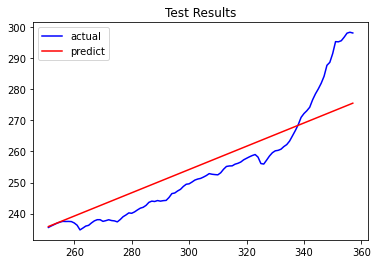

MSE =  65.56631047408236


In [76]:
plt.plot(cpi[math.ceil(len(cpi) * .7):], color = 'blue', label = 'actual') 
plt.plot(result, color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()
print('MSE = ', np.mean((X_test - result) ** 2))

We can conclude that adding extra infromation from the training residuals is not sufficient to even create a noticable change in the original $ARIMA(1,1,2)$ model. Thus, it is better to use only the original ARIMA model.